In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Dense, Reshape, Add, ReLU, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


In [10]:
# Residual Block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])  # Ensure Add is imported
    x = ReLU()(x)
    return x

# Attention Block
def attention_block(x, filters):
    attention = Conv2D(filters, (1, 1), padding='same', activation='sigmoid')(x)
    return attention * x

# Define a more complex convolutional autoencoder with residual blocks and attention mechanism
def build_complex_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 64)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 128)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 256)
    
    # Attention Block
    x = attention_block(x, 256)
    
    # Bottleneck
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Decoder
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = residual_block(x, 256)
    
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = residual_block(x, 128)
    
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = residual_block(x, 64)
    
    output_img = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Create and compile the autoencoder
    autoencoder = Model(input_img, output_img)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())
    
    return autoencoder


In [10]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import glob
import os

def load_images_from_folder(folder, img_size):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.jpg')):
        img = load_img(filename, target_size=img_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Define image size
img_size = (64, 64)

# Directories for training data
sketch_dir = 'D:\\kaushik\\MSC\\Projects\\Sketch to image\\Dataset\\Augmented sketch'
photo_dir = 'D:\\kaushik\\MSC\\Projects\\Sketch to image\\Dataset\\Augmented photo'

# Load training data
x_train = load_images_from_folder(sketch_dir, img_size)  # Sketch images
y_train = load_images_from_folder(photo_dir, img_size)   # Corresponding real images

# Directories for testing data (do not include in training split)
test_sketch = "D:\\kaushik\\MSC\\Projects\\Sketch to image\\Dataset\\CUHK\\Testing sketch"
test_photo = "D:\\kaushik\\MSC\\Projects\\Sketch to image\\Dataset\\CUHK\\Testing photo"

# Load testing data
x_test = load_images_from_folder(test_sketch, img_size)  # Test sketches
y_test = load_images_from_folder(test_photo, img_size)   # Test real images


In [25]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the autoencoder
build_complex_autoencoder.fit(x_train, y_train, epochs=50, batch_size=100, shuffle=True, validation_data=(x_test, y_test),callbacks=[early_stopping])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_5[0][0]  

 Total params: 6,278,403 (23.95 MB)

 Trainable params: 6,272,003 (23.93 MB)

 Non-trainable params: 6,400 (25.00 KB)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 601s 13s/step - loss: 0.0652 - val_loss: 0.0929
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 522s 12s/step - loss: 0.0147 - val_loss: 0.1019
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 503s 11s/step - loss: 0.0109 - val_loss: 0.1072
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 554s 11s/step - loss: 0.0095 - val_loss: 0.1161
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 505s 11s/step - loss: 0.0086 - val_loss: 0.1184
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 501s 11s/step - loss: 0.0081 - val_loss: 0.1162
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 503s 11s/step - loss: 0.0076 - val_loss: 0.1089
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 503s 11s/step - loss: 0.0072 - val_loss: 0.0806
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 495s 11s/step - loss: 0.0069 - val_loss: 0.0516
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - loss: 0.0066 - val_loss: 0.0370
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 497s 11s/step - loss: 0.0063 - val_loss: 0.0288
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 503s 11s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


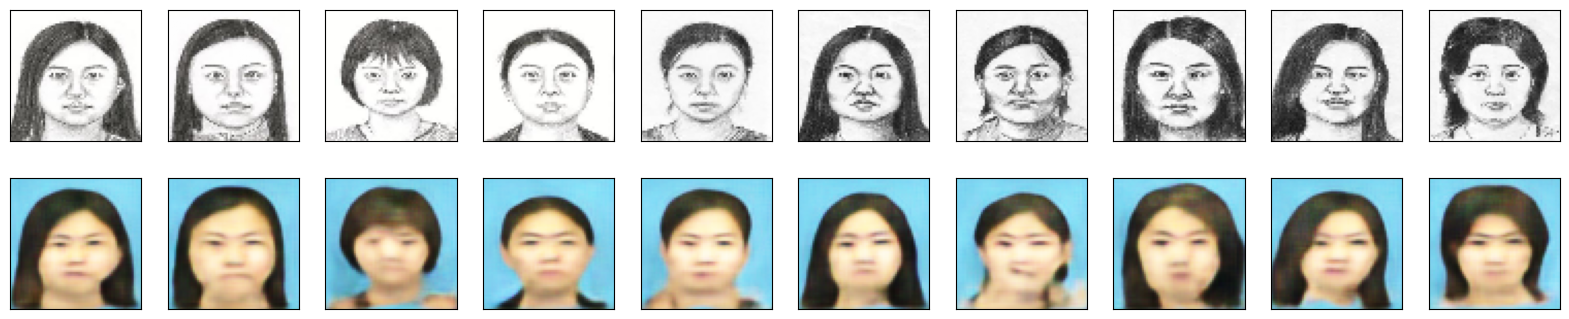

In [27]:
import matplotlib.pyplot as plt

# Predict on test data
decoded_imgs = autoencoder.predict(x_test)

# Plot original and reconstructed images
def plot_images(orig, recon, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_images(x_test, decoded_imgs)


In [29]:
from tensorflow.keras.models import load_model

In [31]:
# Save the entire model in .keras format
autoencoder.save('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_model_keras.keras')

# Save model weights
autoencoder.save_weights('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_weights.weights.h5')

# Save model .h5
autoencoder.save('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_model_h5.h5')

In [32]:
import json

# Save model architecture to JSON
model_json = autoencoder.to_json()
with open('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_model_json.json', 'w') as json_file:
    json_file.write(model_json)

In [38]:
from tensorflow.keras.models import load_model

# Load the previously saved model
new_autoencoder = load_model('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_model_further_trained.keras')

# Continue training for additional epochs (e.g., 10 more epochs)
history = new_autoencoder.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    initial_epoch=60,  # Start from where you left off
                    epochs=80,          # New total epoch number (50 + 10)
                    batch_size=25)

# Save the model again after further training if needed
new_autoencoder.save('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_model_trained.keras')

Epoch 61/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - loss: 0.0025 - val_loss: 0.0210
Epoch 62/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - loss: 0.0025 - val_loss: 0.0200
Epoch 63/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - loss: 0.0024 - val_loss: 0.0195
Epoch 64/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - loss: 0.0024 - val_loss: 0.0202
Epoch 65/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - loss: 0.0024 - val_loss: 0.0206
Epoch 66/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - loss: 0.0023 - val_loss: 0.0206
Epoch 67/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - loss: 0.0022 - val_loss: 0.0214
Epoch 68/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - loss: 0.0022 - val_loss: 0.0211
Epoch 69/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - loss: 0.0022 - val_loss: 0.0207
Epoch 70/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - loss: 0.0021 - val_loss: 0.0209
Epoch 71/80
176/176 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - loss: 0.0021 - val_loss: 0.0206
Epoch 72/80
176/176 ━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


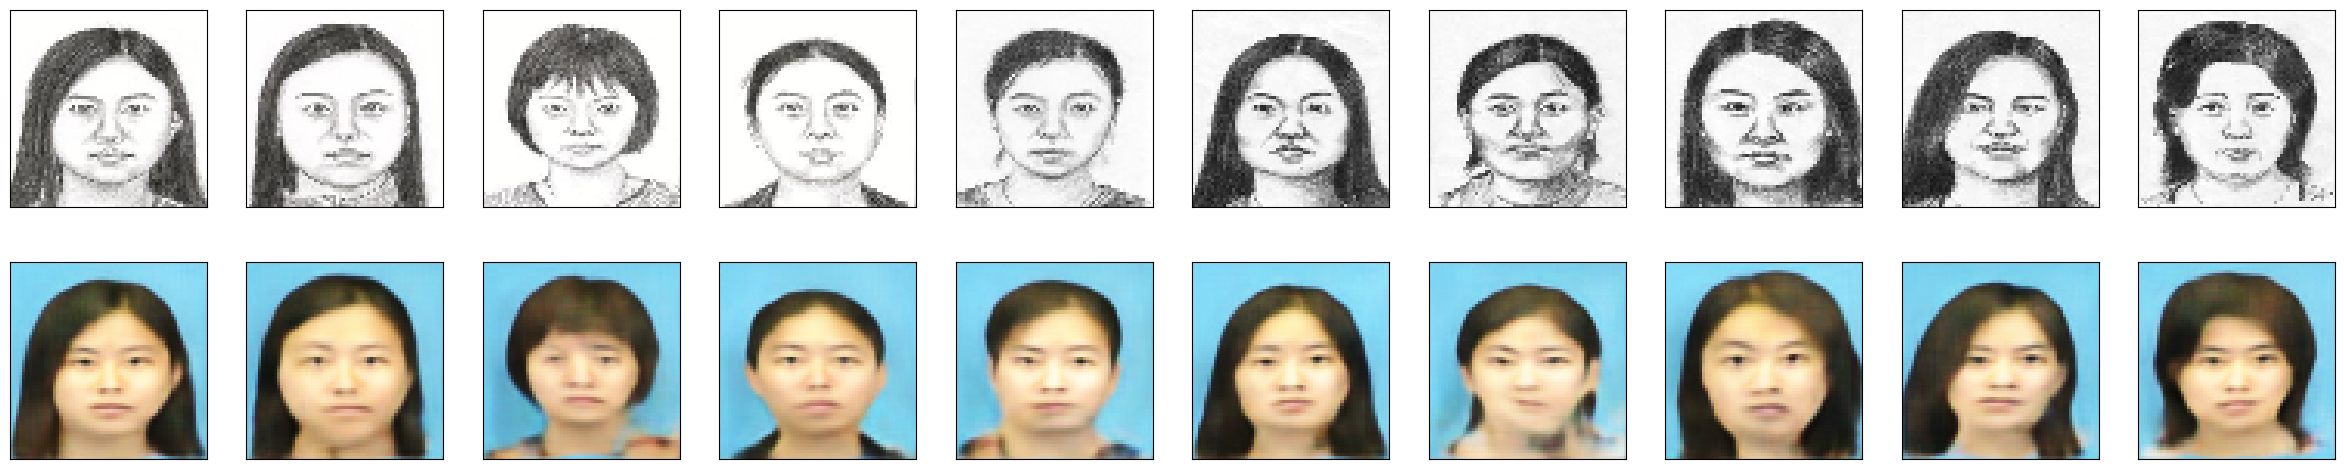

In [15]:
import matplotlib.pyplot as plt

# Predict on test data
decoded_imgs = new_autoencoder.predict(x_test)

# Plot original and reconstructed images
def plot_images(orig, recon, n=10):
    plt.figure(figsize=(30, 6))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_images(x_test, decoded_imgs)

In [41]:
# Save the entire model in .keras format
new_autoencoder.save('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_final_keras.keras')

# Save model weights
new_autoencoder.save_weights('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_final.weights.h5')

# Save model .h5
new_autoencoder.save('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_final_h5.h5')

import json

# Save model architecture to JSON
model_json = new_autoencoder.to_json()
with open('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_final_json.json', 'w') as json_file:
    json_file.write(model_json)

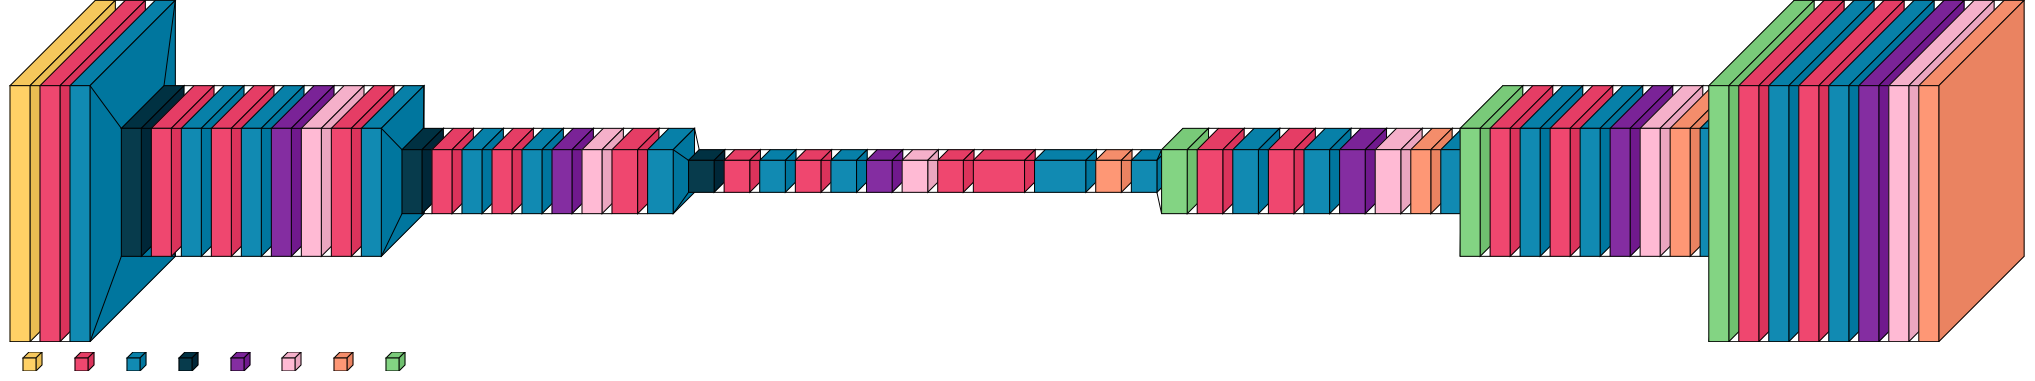

In [23]:
from tensorflow.keras.models import model_from_json

# Load model architecture from JSON
with open('D:\\kaushik\\MSC\\Projects\\Sketch to image\\models\\autoencoder_final_json.json', 'r') as json_file:
    model_json = json_file.read()

# Recreate the model from architecture
model = model_from_json(model_json)

import visualkeras
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font # without custom font

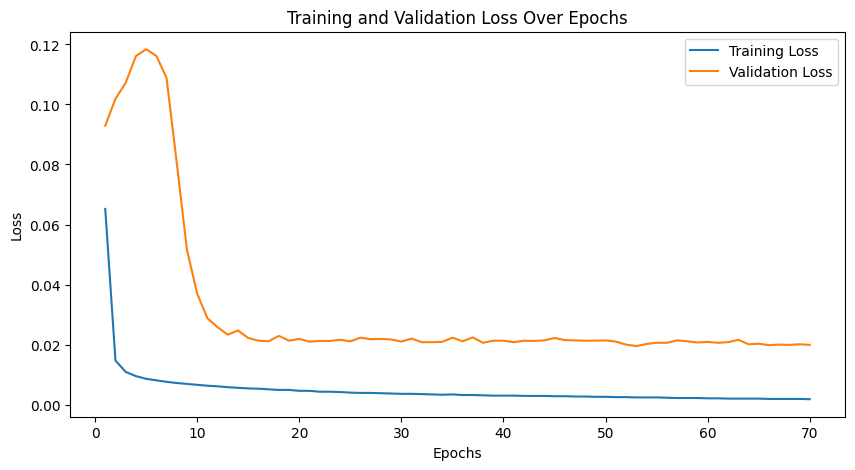

In [3]:
import matplotlib.pyplot as plt

# Manually entered loss and validation loss values from the log
epochs = range(1, 71)  # For 80 epochs

loss = [0.0652, 0.0147, 0.0109, 0.0095, 0.0086, 0.0081, 0.0076, 0.0072, 0.0069, 0.0066,
        0.0063, 0.0061, 0.0058, 0.0056, 0.0054, 0.0053, 0.0051, 0.0049, 0.0049, 0.0046,
        0.0046, 0.0043, 0.0043, 0.0042, 0.0040, 0.0039, 0.0039, 0.0038, 0.0037, 0.0036,
        0.0036, 0.0035, 0.0034, 0.0033, 0.0034, 0.0032, 0.0032, 0.0031, 0.0030, 0.0030,
        0.0030, 0.0029, 0.0029, 0.0029, 0.0028, 0.0028, 0.0027, 0.0027, 0.0026, 0.0026,
        0.0025, 0.0025, 0.0024, 0.0024, 0.0024, 0.0023, 0.0022, 0.0022, 0.0022, 0.0021,
        0.0021, 0.0020, 0.0020, 0.0020, 0.0020, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018]

val_loss = [0.0929, 0.1019, 0.1072, 0.1161, 0.1184, 0.1162, 0.1089, 0.0806, 0.0516, 0.0370,
            0.0288, 0.0258, 0.0233, 0.0247, 0.0222, 0.0213, 0.0211, 0.0229, 0.0213, 0.0219,
            0.0210, 0.0212, 0.0212, 0.0216, 0.0211, 0.0223, 0.0218, 0.0219, 0.0217, 0.0210,
            0.0220, 0.0208, 0.0208, 0.0209, 0.0223, 0.0211, 0.0224, 0.0206, 0.0213, 0.0213,
            0.0208, 0.0213, 0.0212, 0.0214, 0.0222, 0.0215, 0.0214, 0.0213, 0.0213, 0.0214,
            0.0210, 0.0200, 0.0195, 0.0202, 0.0206, 0.0206, 0.0214, 0.0211, 0.0207, 0.0209,
            0.0206, 0.0208, 0.0216, 0.0201, 0.0203, 0.0198, 0.0200, 0.0199, 0.0201, 0.0199]

# Step 2: Plot the loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Step 3: Customize the plot
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Step 4: Show the plot
plt.show()


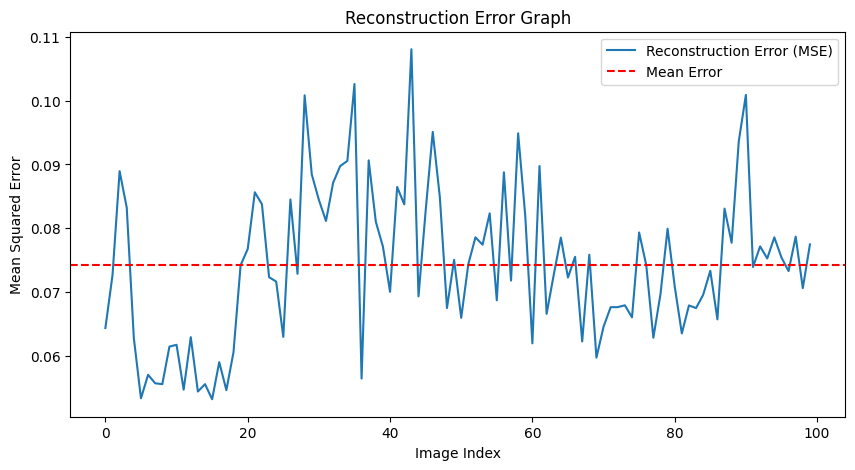

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `x_test` contains your original images (sketches)
# and `decoded_imgs` contains the reconstructed images

# Compute the reconstruction errors
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=(1, 2, 3))  # MSE for each image

# Plot the reconstruction error graph
def plot_reconstruction_error(errors):
    plt.figure(figsize=(10, 5))
    plt.plot(errors, label='Reconstruction Error (MSE)')
    plt.title('Reconstruction Error Graph')
    plt.xlabel('Image Index')
    plt.ylabel('Mean Squared Error')
    plt.axhline(y=np.mean(errors), color='r', linestyle='--', label='Mean Error')
    plt.legend()
    plt.show()

# Call the function to plot the reconstruction errors
plot_reconstruction_error(reconstruction_errors)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


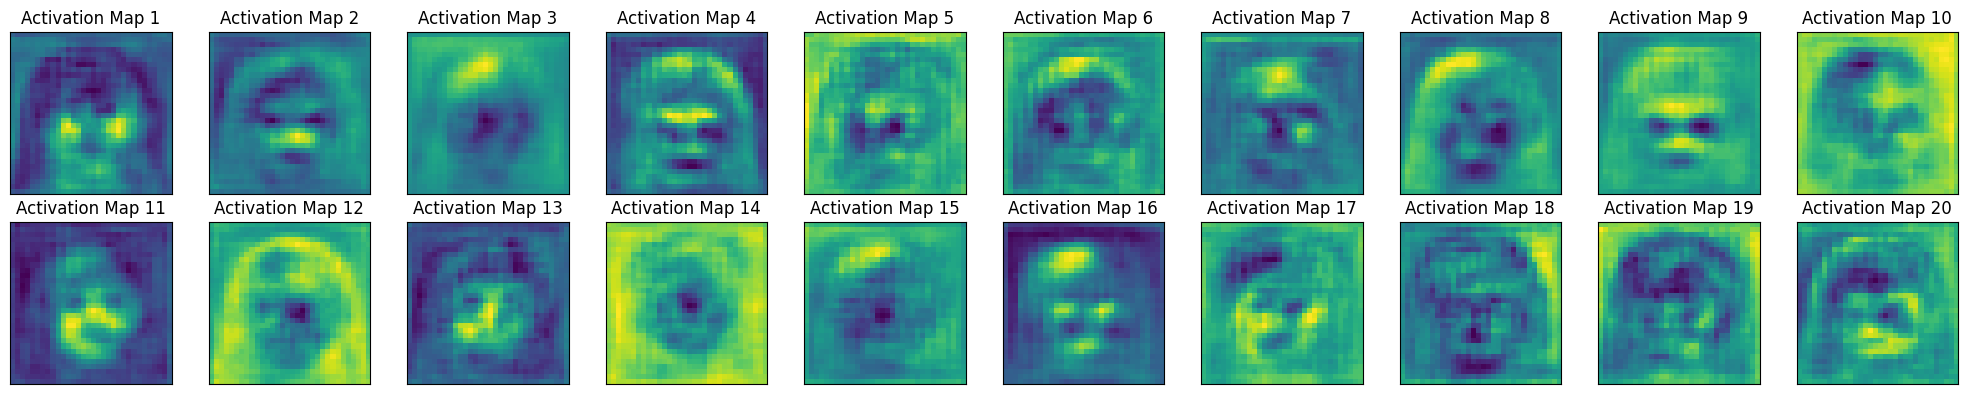

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

# Select a specific layer to visualize (replace 'layer_name' with your layer's name)
layer_name = 'conv2d_14'  # Example: First convolutional layer
layer_model = Model(inputs=new_autoencoder.input, outputs=new_autoencoder.get_layer(layer_name).output)

# Choose an index for the image you want to visualize (e.g., sketch index 0)
sample_index = 0
sample_image = np.expand_dims(x_test[sample_index], axis=0)  # Add batch dimension

# Get the activation maps
activations = layer_model.predict(sample_image)

# Plot the first 20 activation maps
def plot_activation_maps(activations, n_cols=10, max_maps=20):
    n_features = min(max_maps, activations.shape[-1])  # Limit to first 20 activations
    n_rows = n_features // n_cols + int(n_features % n_cols > 0)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_features):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')  # Use a colormap for visualization
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(f'Activation Map {i + 1}')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the first 20 activation maps
plot_activation_maps(activations)
